In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
trial1_raw = pd.read_csv("11212022 RAG2KO in vitro expression/repeat_Rag2KO_invitro_expression_11282022.csv")
trial2_raw = pd.read_csv("11212022 RAG2KO in vitro expression/12052022_Trial2_ Rag2_KO ProB in Vitro Culture Expression.csv")

In [3]:
# Rename the Ct mean to be universal
trial1_raw.rename(columns= {'Cт Mean': "Ct Mean"}, inplace=True)
trial2_raw.rename(columns= {"C? Mean" : "Ct Mean"}, inplace=True)

In [4]:
# drop duplicates 
trial1_raw.drop_duplicates(subset="Ct Mean", keep='first', inplace=True)
trial2_raw.drop_duplicates(subset="Ct Mean", keep='first', inplace=True)

In [5]:
trial1_raw.columns

Index(['Well', 'Sample Name', 'Target Name', 'Task', 'Reporter', 'Quencher',
       'RQ', 'RQ Min', 'RQ Max', 'Cт', 'Ct Mean', 'Cт SD', 'ΔCт', 'ΔCт Mean',
       'ΔCт SE', 'HK Control ΔCт Mean', 'HK Control ΔCт SE', 'ΔΔCт',
       'Automatic Ct Threshold', 'Ct Threshold', 'Automatic Baseline',
       'Baseline Start', 'Baseline End', 'Efficiency', 'Tm1', 'Tm2', 'Tm3',
       'Comments', 'AMPNC', 'HIGHSD'],
      dtype='object')

In [6]:
# slice to only columns of interest
interest = ['Sample Name', 'Target Name', "Ct Mean"]

trial1_sliced = trial1_raw.loc[:, interest]
trial2_sliced = trial2_raw.loc[:, interest]

In [7]:
# merge the two dataframes to have both trials and create a mean
data = pd.merge(trial1_sliced, trial2_sliced, on=["Sample Name", "Target Name"], how= "inner")

In [8]:
# average the two ct mean columns 
data["Average Ct Mean"] = data.loc[:, ["Ct Mean_x", "Ct Mean_y"]].mean(axis=1)

In [9]:
samples = ['Rag2KO Day 0', 'Rag2KO Day 4 2 ng/ml IL-7', 'Rag2KO Day 7 2 ng/ml IL-7']
controls = ["18s", "HIS3.3", "GAPDH"]

In [23]:
# create a function that looks at one sample and creates a delta ct to specific control
def to_control(df, specimen_list, control_list):
    """Takes in a qpcr dataframe, a experiment "specimen or sample" list , list of controls"""

    # get only current sample data
    frames = []
    for specimen in specimen_list:
        # create a dataframe with current sample 
        sample_df = df.iloc[df[df["Sample Name"].str.contains(specimen)].index]
        # find the mean for the given control
        sample_df.reset_index(drop=True, inplace=True)
        # control_row = sample_df.iloc[sample_df[sample_df["Target Name"].str.contains(control)].index]
        # control_mean = list(control_row["Ct Mean"])
        # control_mean = control_mean[0]
        for control in control_list: 
            index = sample_df[sample_df["Target Name"].str.contains(control)].index
            control_mean = sample_df.at[index[0], "Average Ct Mean"]
            delta_ct = []
            for target_mean in sample_df["Average Ct Mean"]:
                delta = control_mean - target_mean
                deltact = 2**delta
                delta_ct.append(deltact)
            new_col = "Delta Ct to " + control
            sample_df[new_col] = np.array(delta_ct)
            #merge the new columns onto the sample dataframe
        frames.append(sample_df)
    
    new_df = pd.concat(frames, ignore_index=True)
    
    return new_df


In [24]:
analyzed_df = to_control(data, samples, controls )

C:\Users\bianchiah\AppData\Local\Temp\ipykernel_2892\3462717448.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[new_col] = np.array(delta_ct)
C:\Users\bianchiah\AppData\Local\Temp\ipykernel_2892\3462717448.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df[new_col] = np.array(delta_ct)
C:\Users\bianchiah\AppData\Local\Temp\ipykernel_2892\3462717448.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [68]:
def get_sample_plot(sample_name, analyzed_data, controls_list):
    #get plot of Day 0
    fig, ax = plt.subplots()
    # get a list of x labels, without the controls
    X = list(analyzed_data["Target Name"].unique())
    X = [targ for targ in X if not targ in controls_list]
    # create the x axis locations
    x = np.arange(len(X))
    # create a df that only comtains the sample of interest
    sample_df = analyzed_df.iloc[analyzed_data[analyzed_data["Sample Name"].str.contains(sample_name)].index]
    # pandas.Dateframe.isin will return boolean values depending on whether each element is inside the list a or not. You then invert this with the ~ to convert True to False and vice versa.
    sample_df = sample_df[~sample_df["Target Name"].isin(controls_list)]

    ys =[sample_df["Delta Ct to " + control] for control in controls_list]
    # add the bars for each control
    one = ax.bar(x- 0.2, ys[0], width=0.2, label=controls_list[0], align="center")
    two = ax.bar(x, ys[1], label=controls_list[1], width=0.2, align="center")
    three = ax.bar(x + .2 ,ys[2], width=0.2, label=controls_list[2], align="center")
    ax.set_title( sample_name + " RNA Expression to Controls")
    ax.set_xticks(x+0.2)
    ax.set_xticklabels(X)
    ax.legend()

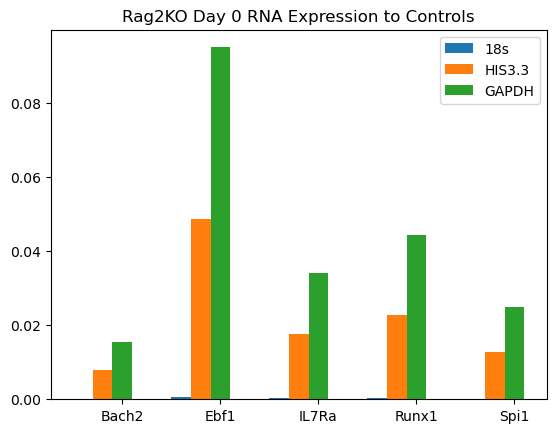

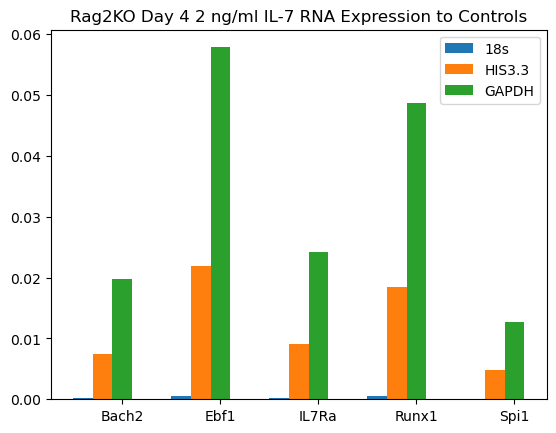

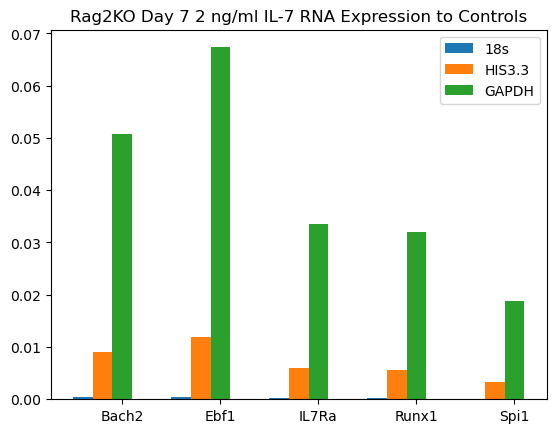

In [69]:
get_sample_plot("Rag2KO Day 0", analyzed_data=analyzed_df, controls_list=controls)
get_sample_plot("Rag2KO Day 4 2 ng/ml IL-7", analyzed_data=analyzed_df, controls_list=controls)
get_sample_plot("Rag2KO Day 7 2 ng/ml IL-7", analyzed_data=analyzed_df, controls_list=controls)